In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib nbagg
%matplotlib inline
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
import sys
sys.path.append('/Users/keceli/G/work/f3n')
from ffn.utils import bounding_box
from time import time
import h5py
import numpy as np
import matplotlib.pyplot as plt
import ffntools as ft
import imageio
from ipywidgets import interact, interactive, fixed, interact_manual, Textarea,widgets, IntSlider

/Users/keceli/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Flood-Filling Networks

Flood-Filling Networks (FFNs) are a class of neural networks designed for
instance segmentation of complex and large shapes, particularly in volume
EM datasets of brain tissue.

For more details, see the related publications:

 * https://arxiv.org/abs/1611.00421
 * https://doi.org/10.1101/200675
 
## Preparing the training data

`compute_partitions.py` transforms the label volume into an intermediate
volume where the value of every voxel `A` corresponds to the quantized
fraction of voxels labeled identically to `A` within a subvolume of
radius `lom_radius` centered at `A`. `lom_radius` should normally be
set to `(fov_size // 2) + deltas` (where `fov_size` and `deltas` are
FFN model settings). Every such quantized fraction is called a *partition*.
Sample invocation:

Computes the partition map for a segmentation.

For every labeled voxel of the input volume, computes the fraction of identically
labeled voxels within a neighborhood of radius `lom_radius`, and then quantizes
that number according to `thresholds`.

```shell
  python compute_partitions.py \
    --input_volume third_party/neuroproof_examples/validation_sample/groundtruth.h5:stack \
    --output_volume third_party/neuroproof_examples/validation_sample/af.h5:af \
    --thresholds 0.025,0.05,0.075,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9 \
    --lom_radius 24,24,24 \
    --min_size 10000
```

* --input_volume:  (None) Segmentation volume as <volume_path>:<dataset>, where volume_path points to a HDF5 volume.
* --output_volume: (None) Volume in which to save the partition map, as'<volume_path>:<dataset>.
* --thresholds:    (None) List of activation voxel fractions used for partitioning.
* --lom_radius:    (None) Local Object Mask (LOM) radii as (x, y, z).
* --min_size:      (10000) Minimum number of voxels for a segment to be considered for partitioning.
* --id_whitelist:  (None) Whitelist of object IDs for which to compute the partition numbers.
* --mask_configs: (None) MaskConfigs proto in text foramt. Any locations where at least one voxel of the LOM is masked will be marked as excluded.
* --exclusion_regions (None) List of (x, y, z, r) tuples specifying spherical regions to mark as excluded (i.e. set the output value to 255)

## What is the ground truth for fib25 dataset?
The raw .png images were converted into h5 files using the png_to_h5.py script.

Dataset originates from FlyEM (http://janelia.org/team-project/fly-em) and their efforts to reconstruct neurons from the Drosophila medulla prepared using FIB-SEM imaging. FIB-SEM data and segmentation ground truth from FlyEM's
neuroproof GitHub repository:

  https://github.com/janelia-flyem/neuroproof_examples


neuroproof_examples/validation_sample/groundtruth.h5: Hierarchical Data Format (version 5) contain segmentation as a combination of two datasets: 'stack' and 'transforms'.  'stack' is a 3D volume (z,y,x) of supervoxel labels.  'transforms' is a mapping of supervoxels to bodies.  In some cases, 'transforms' is simply an identify and 'stack' represents the final segmentation or ground truth.

* stack: 
Shape:  (520, 520, 520)
Datatype:  int64
Unique:  2084
Min:  2
Max:  6210
Mean:  1433.22
520x520x520 volume from the Drosophila
medulla at 10nm isotropic pixel resolution.
Each pixel is represented by a single integer in range (2,6210)
No attributes. (no bounding box)

* transforms:
Shape:  (2084, 2)
Datatype:  uint64
Unique:  2084
Min:  2
Max:  6210
Mean:  2396.08

Column 0 and Column 1 of this dataset is identical. Rows corresponds to the grayscale in stack ()

* synapse-annotations:
This is the third dataset in groundtruth.h5 and not mentioned in README files from Janelia or ffn.  This dataset contains a json file that identifies neurons (T-bar) and their partners with body IDs and locations.
There are 260 T-bars annotated. T-bars have min 1 to max 15 partners. Out of 260 T-bars, 72 of them have unique body-ids. Including partners and T-bars there are 596 unique body IDs. T-bar body IDs range from 3 to 5014, partner body IDs range from 1 to 5522. 


In [3]:
path_gt = '/Users/keceli/G/work/ffn/third_party/neuroproof_examples/validation_sample/groundtruth.h5'
f_gt = h5py.File(path_gt,'r')
img_gt = f_gt['stack']
path_gray = '/Users/keceli/G/work/ffn/third_party/neuroproof_examples/validation_sample/grayscale_maps.h5'
f_gray = h5py.File(path_gray,'r')
img_gray = f_gray['raw']
path_pt_def   = '/Users/keceli/G/work/f3n/data/full_af.h5'
path_pt_min   = '/Users/keceli/G/work/f3n/profiles/mac_profile1/af.h5'
path_pt_lom   = '/Users/keceli/G/work/f3n/partitions/lom111/af.h5'
path_pt_lom50 = '/Users/keceli/G/work/f3n/partitions/lom50/af.h5'
path_pt_thr   = '/Users/keceli/G/work/f3n/partitions/thresh0025/af.h5'
path_pt_thr09 = '/Users/keceli/G/work/f3n/partitions/thresh09/af.h5'

f_pt_def   = h5py.File(path_pt_def,'r')
f_pt_min   = h5py.File(path_pt_min,'r')
f_pt_lom   = h5py.File(path_pt_lom,'r')
f_pt_lom50 = h5py.File(path_pt_lom50,'r')
f_pt_thr   = h5py.File(path_pt_thr,'r')
f_pt_thr09 = h5py.File(path_pt_thr09,'r')
img_pt_def = f_pt_def['af']
img_pt_min = f_pt_min['af']
img_pt_lom = f_pt_lom['af']
img_pt_lom50 = f_pt_lom50['af']
img_pt_thr   = f_pt_thr['af']
img_pt_thr09 = f_pt_thr09['af']

titles = ['Original','Groundtruth', 'Default Partition', 'Min: 4m, nlabel=6', 
          'Min: 4m , LOM: 1', 'Min: 4m, LOM: 50', 
          'Min: 4m , Thr = 0.025','Min: 4m, Thr = 0.9']
images = [None,           img_gt,     img_pt_def, img_pt_min, img_pt_lom, img_pt_lom50, img_pt_thr, img_pt_thr09  ]
print('Total number of unique labels in original: {}'.format(len(np.unique(img_gray))))
print('Total number of unique labels in groundtruth: {}'.format(len(np.unique(img_gt))))
def compare_images(images,titles,idx,cmap='nipy_spectral_r'):
    nimage = len(images)
    plt.figure(figsize=(20,6))
    print('***Default partition parameters***')
    print('Min number of voxels for a segment: 10000')
    print('Local Object Mask (LOM) radii     : 24,24,24')
    print('Activation voxel fractions        : [0.025,0.05,0.075,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]')
    print('Number of unique labels           : 637')
    for i,img in enumerate(images):
        if i == 0:
            path = '/Users/keceli/G/work/neuroproof_examples/validation_sample/grayscale_maps/iso.0{}.png'.format(str(3490+idx))
            img  = imageio.imread(path)
        else:
            img = img[idx]
        uniques, counts = np.unique(img,return_counts=True)
#        title = '{} {}, [{},{}]\n Unique counts: {} {} {}'.format(titles[i],img.shape,np.min(img),np.max(img),
#                                      len(uniques),np.min(counts),np.max(counts))
        plt.subplot(2,nimage,i+1)
        plt.imshow(img,cmap=cmap)
        plt.axis('off')
        plt.title(titles[i])
        plt.subplot(2,nimage,i+nimage+1)
        plt.scatter(uniques,counts,s=2,alpha=0.5)
        plt.yscale('log')
        plt.title('{} unique values'.format(len(uniques)))
interact(compare_images,images=fixed(images), titles=fixed(titles),
         idx=IntSlider(min=0,max=511,step=1,value=24,continuous_update=False,description='image index'),
         cmap=['Greys_r','Greys','viridis','binary','nipy_spectral_r']
        )

Total number of unique labels in original: 200
Total number of unique labels in groundtruth: 2084


interactive(children=(IntSlider(value=24, continuous_update=False, description='image index', max=511), Dropdo…

<function __main__.compare_images(images, titles, idx, cmap='nipy_spectral_r')>

In [2]:
img_org = imageio.imread('/Users/keceli/G/work/f3n/third_party/neuroproof_examples/validation_sample/iso.03490.png')
#display_image(0)
@interact(idx=IntSlider(min=0,max=511,step=1,value=25),cmap=['Greys_r','Greys','viridis','binary','nipy_spectral_r'])
def display_image(idx,cmap='Greys_r',figx=20):
    path_org  = '/Users/keceli/G/work/neuroproof_examples/validation_sample/grayscale_maps/'
    path_org += 'iso.0{}.png'.format(str(3490+idx))
    img_org   = imageio.imread(path_org)
    path_gt = '/Users/keceli/G/work/ffn/third_party/neuroproof_examples/validation_sample/groundtruth.h5'
    f_gt = h5py.File(path_gt,'r')
    img_gt = f_gt['stack'][idx]
    path_pt = '/Users/keceli/G/work/f3n/data/full_af.h5'
    path_pt = '/Users/keceli/G/work/f3n/profiles/mac_profile1/af.h5'
    path_pt2 = '/Users/keceli/G/work/f3n/partitions/lom111/af.h5'
    #path_pt2 = '/Users/keceli/G/work/f3n/partitions/thresh0025/af.h5'
    f_pt = h5py.File(path_pt,'r')
    img_pt = f_pt['af'][idx]
    f_pt2 = h5py.File(path_pt2,'r')
    img_pt2 = f_pt2['af'][idx]
    unique_gt, count_gt = np.unique(img_gt,return_counts=True)
    unique_pt, count_pt = np.unique(img_pt,return_counts=True)
    unique_pt2, count_pt2 = np.unique(img_pt2,return_counts=True)
    unique_org, count_org = np.unique(img_org,return_counts=True)
    print('Shapes: {} {} {} {}'.format(img_org.shape,img_gt.shape,img_pt.shape,img_pt2.shape))
    print('Ranges: [{},{}] [{},{}] [{},{}] [{},{}]'.format(np.min(img_org),np.max(img_org),np.min(img_gt),np.max(img_gt),np.min(img_pt),np.max(img_pt),np.min(img_pt2),np.max(img_pt2)))
    print('Number of unique elements   : {} {} {} {}'.format(len(unique_org),len(unique_gt),len(unique_pt),len(unique_pt2)))
    print('Min count of unique elements: {} {} {} {}'.format(min(count_org),min(count_gt),min(count_pt),min(count_pt2)))
    print('Max count of unique elements: {} {} {} {}'.format(max(count_org),max(count_gt),max(count_pt),max(count_pt2)))

    plt.figure(figsize=(figx,10))
    plt.subplot(1,4,1)
    plt.imshow(img_org,cmap=cmap)
    plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(img_gt,cmap=cmap)
    plt.axis('off')
    plt.subplot(1,4,3)
    plt.imshow(img_pt,cmap=cmap)
    plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(img_pt2,cmap=cmap)
    plt.axis('off')
   # plt.show()

interactive(children=(IntSlider(value=25, description='idx', max=511), Dropdown(description='cmap', options=('…

In [4]:
path_gt = '/Users/keceli/G/work/ffn/third_party/neuroproof_examples/validation_sample/groundtruth.h5'
f_gt = h5py.File(path_gt,'r')
img_gt = f_gt['stack']
path_gray = '/Users/keceli/G/work/ffn/third_party/neuroproof_examples/validation_sample/grayscale_maps.h5'
f_gray = h5py.File(path_gray,'r')
img_gray = f_gray['raw']
path_pt_def   = '/Users/keceli/G/work/f3n/data/full_af.h5'
path_pt_min   = '/Users/keceli/G/work/f3n/profiles/mac_profile1/af.h5'
path_pt_lom   = '/Users/keceli/G/work/f3n/partitions/lom111/af.h5'
path_pt_lom50 = '/Users/keceli/G/work/f3n/partitions/lom50/af.h5'
path_pt_thr   = '/Users/keceli/G/work/f3n/partitions/thresh0025/af.h5'
path_pt_thr09 = '/Users/keceli/G/work/f3n/partitions/thresh09/af.h5'

f_pt_def   = h5py.File(path_pt_def,'r')
f_pt_min   = h5py.File(path_pt_min,'r')
f_pt_lom   = h5py.File(path_pt_lom,'r')
f_pt_lom50 = h5py.File(path_pt_lom50,'r')
f_pt_thr   = h5py.File(path_pt_thr,'r')
f_pt_thr09 = h5py.File(path_pt_thr09,'r')
img_pt_def = f_pt_def['af']
img_pt_min = f_pt_min['af']
img_pt_lom = f_pt_lom['af']
img_pt_lom50 = f_pt_lom50['af']
img_pt_thr   = f_pt_thr['af']
img_pt_thr09 = f_pt_thr09['af']

titles = ['Original','Groundtruth', 'Default Partition', 'Min: 4m, nlabel=6', 
          'Min: 4m , LOM: 1', 'Min: 4m, LOM: 50', 
          'Min: 4m , Thr = 0.025','Min: 4m, Thr = 0.9']
images = [img_gray,           img_gt,     img_pt_def, img_pt_min, img_pt_lom, img_pt_lom50, img_pt_thr, img_pt_thr09  ]
#print('Total number of unique labels in grayscale: {}'.format(len(np.unique(img_gray))))
print('Total number of unique labels in groundtruth: {}'.format(len(np.unique(img_gt))))
def compare_images(images,titles,idx,label,cmap='nipy_spectral_r'):
    nimage = len(images)
    plt.figure(figsize=(20,6))
    print('***Default partition parameters***')
    print('Min number of voxels for a segment: 10000')
    print('Local Object Mask (LOM) radii     : 24,24,24')
    print('Activation voxel fractions        : [0.025,0.05,0.075,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]')
    print('Number of unique labels           : 637')
    for i,img in enumerate(images):
        img = img[idx]
        img[img_gt[idx] != label] = 255
        uniques, counts = np.unique(img,return_counts=True)
#        title = '{} {}, [{},{}]\n Unique counts: {} {} {}'.format(titles[i],img.shape,np.min(img),np.max(img),
#                                      len(uniques),np.min(counts),np.max(counts))
        plt.subplot(2,nimage,i+1)
        plt.imshow(img,cmap=cmap)
        plt.axis('off')
        plt.title(titles[i])
        plt.subplot(2,nimage,i+nimage+1)
        plt.scatter(uniques,counts,s=2,alpha=0.5)
        plt.yscale('log')
        plt.title('{} unique values'.format(len(uniques)))
interact(compare_images,images=fixed(images), titles=fixed(titles),
         idx=IntSlider(min=0,max=511,step=1,value=24,continuous_update=False,description='image index'),
         label=[  34 , 103, 1236, 2104, 2148, 2617],
         cmap=['Greys_r','Greys','viridis','binary','nipy_spectral_r']
        )

Total number of unique labels in groundtruth: 2084


interactive(children=(IntSlider(value=24, continuous_update=False, description='image index', max=511), Dropdo…

<function __main__.compare_images(images, titles, idx, label, cmap='nipy_spectral_r')>

In [9]:
lom_radius = np.array([24,24,24])
lom_radius_zyx = lom_radius[::-1]
lom_diam_zyx = 2 * lom_radius_zyx + 1
fov_volume = np.prod(lom_diam_zyx)
print(lom_radius_zyx)
print(lom_diam_zyx)
print(fov_volume,fov_volume/520**3*100)

[24 24 24]
[49 49 49]
117649 0.08367162608101958


In [11]:
#gtfile = '/Users/keceli/G/work/neuroproof_examples/validation_sample/groundtruth.h5'
# The above from Janelia is the original one and identical to the below.
gtfile = '/Users/keceli/G/work/ffn/third_party/neuroproof_examples/validation_sample/groundtruth.h5'
gt = h5py.File(gtfile)
gtstack = gt['stack']
gtuniques, gtcounts = np.unique(gtstack,return_counts=True)
def get_number_of_labels(filename,minsize):
    gt = h5py.File(filename)
    gtstack = gt['stack']
    gtuniques, gtcounts = np.unique(gtstack,return_counts=True)
    nlabel = len(gtcounts[gtcounts>minsize])
    return nlabel

In [30]:
t1={int(x) for x in [1,2,3]}
t1 &= set([3])
print(t1)

{3}


637
6
3 445953
5 1176402
11 418599
24 506350
28 982471
30 2559978
34 4493093
37 526603
40 2406604
48 524445
53 1906105
67 3131176
73 1358818
79 952282
88 650648
99 523133
100 3163470
101 1623732
103 4406398
106 1901389
149 1258153
158 434913
171 2786283
194 1510122
318 675122
326 2748825
344 400260
571 1738851
638 470934
640 2471091
668 1333149
1011 421455
1155 1698736
1219 2524088
1229 406367
1233 867261
1236 5072778
1267 616443
1348 926446
1419 784248
1424 1206361
1497 1478189
1505 422347
1522 1619652
1563 752161
1637 978372
1699 691824
1832 710863
1848 936921
1876 829739
1958 792654
2043 555748
2104 4563055
2148 5732788
2191 1333036
2326 440345
2332 612463
2372 1002874
2434 535787
2503 421931
2587 799044
2612 486056
2617 4059765
2779 438140
2865 440596
2906 727458
2972 1526709
2988 480087
3016 443790
3213 938882
3353 516387
3480 846591
3494 1244749
3553 1326570
3614 1487126
3628 718017
3670 552258
3696 525939
3782 635217
3849 777312
4150 469493


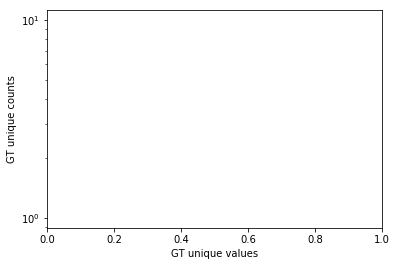

In [33]:
# plt.scatter(gtuniques,gtcounts,c='b',edgecolors='b',alpha=0.25,s=4)
plt.yscale('log')
plt.xlabel('GT unique values')
plt.ylabel('GT unique counts')
print(len(gtcounts[gtcounts>10000]))
print(len(gtcounts[gtcounts>4000000]))
#print(gtuniques[gtcounts>5500000])
#print(min(gtcounts))
for i,cnt in enumerate(gtcounts):
    if cnt>400000:
        print(gtuniques[i],cnt)

(array([   8.,   10.,   13.,   23.,   93.,  429., 1032., 1447., 1771.,
        1931., 1995., 2051., 2077., 2084., 2084.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
        6.5, 7. , 7.5]),
 <a list of 1 Patch objects>)

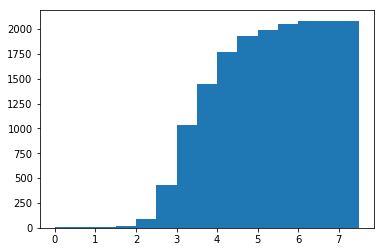

In [147]:
x=np.arange(0,8,0.5)
plt.hist(np.log10(gtcounts),x,histtype='stepfilled',cumulative=True)#,log=True,bins=20)

In [150]:
ptfile = '/Users/keceli/G/work/f3n/data/full_af.h5'
ft.get_h5info(ptfile,showvalues=True)


/ has 1 datasets
Datasets: ['af']
****************************************************************************************************
Dataset  af
Shape:  (520, 520, 520)
Datatype:  uint8
Unique:  15
Min:  0
Max:  255
Mean:  70.26748992944925
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False
Attributes for  af
--------------------------------------------------
name: bounding_boxes
value: [[[ 24  24  24]
  [472 472 472]]]
--------------------------------------------------
name: partition_counts
value: [[       0        1        2        3        4        5        6        7
         8        9       10       11       12       13]
 [ 1950313   152169  2298482  3771924  3760250 11226931  9552541 11414567
  13567244 13263247 11077441  8687871  6896361  7534707]]


<HDF5 file "full_af.h5" (mode r)>

In [41]:
ptfile_7labels = '/Users/keceli/G/work/ffn/third_party/neuroproof_examples/validation_sample/grayscale_maps.h5'
ft.get_h5info(ptfile_7labels,showvalues=True)

/ has 1 datasets
Datasets: ['raw']
****************************************************************************************************
Dataset  raw
Shape:  (520, 520, 520)
Datatype:  uint8
Unique:  200
Min:  20
Max:  221
Mean:  128.65279252247382
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False


<HDF5 file "grayscale_maps.h5" (mode r)>

In [166]:
ptfile = '/Users/keceli/G/work/f3n/partitions/lom111/af.h5'
ft.get_h5info(ptfile,showvalues=True)

/ has 1 datasets
Datasets: ['af']
****************************************************************************************************
Dataset  af
Shape:  (520, 520, 520)
Datatype:  uint8
Unique:  13
Min:  0
Max:  255
Mean:  5.479478002674101
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False
Attributes for  af
--------------------------------------------------
name: bounding_boxes
value: [[[  1   1   1]
  [518 518 518]]]
--------------------------------------------------
name: partition_counts
value: [[        0         2         3         5         6         7         8
          9        10        11        12        13]
 [110847044         1       177      3717     18083     32617    162707
     564585    561170    742353    952750  25106628]]


<HDF5 file "af.h5" (mode r)>

In [168]:
ptfile = '/Users/keceli/G/work/f3n/partitions/thresh0025/af.h5'
ft.get_h5info(ptfile,showvalues=True)

/ has 1 datasets
Datasets: ['af']
****************************************************************************************************
Dataset  af
Shape:  (520, 520, 520)
Datatype:  uint8
Unique:  4
Min:  0
Max:  255
Mean:  64.63817181099226
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False
Attributes for  af
--------------------------------------------------
name: bounding_boxes
value: [[[ 24  24  24]
  [472 472 472]]]
--------------------------------------------------
name: partition_counts
value: [[       0        1        2]
 [81208865     4064 23941119]]


<HDF5 file "af.h5" (mode r)>

##### jsonfile='synaps.json'
import json
f= open(jsonfile, 'r') 
synaps = json.load(f)
synapsdata = synaps['data']
print(len(synapsdata))
ntbar = len(synapsdata)
tbarids = np.zeros(ntbar,dtype=np.uint32)
tbarnbrs = np.zeros(ntbar,dtype=np.uint32)
partnerids = []
for i,dat in enumerate(synapsdata):
    tbarids[i] = int(dat['T-bar']['body ID'])
    tbarnbrs[i] = len(dat['partners'])
    for p in dat['partners']:
        partnerids.append(p['body ID'])
print(len(list(set(tbarids))))
print(list(set(tbarids)))
print(min(tbarnbrs),max(tbarnbrs))
print(len(list(set(partnerids))))
print(list(set(partnerids)))
print(type(partnerids),type(list(tbarids)),type(partnerids.append(1)))
partnerids.extend(list(tbarids))
print(len(list(set(partnerids))))
print(len(np.unique(tbarids)))
print(min(tbarids),max(tbarids))
print(min(partnerids),max(partnerids))

In [73]:
ft.get_h5info(gtfile,showvalues=True)

/ has 3 datasets
Datasets: ['stack', 'synapse-annotations', 'transforms']
****************************************************************************************************
Dataset  stack
Shape:  (520, 520, 520)
Datatype:  int64
Unique:  2084
Min:  2
Max:  6210
Mean:  1433.2200727056781
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False
****************************************************************************************************
Dataset  synapse-annotations
Shape:  (1,)
Datatype:  object
  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False
****************************************************************************************************
Dataset  transforms
Shape:  (2084, 2)
Datatype:  uint64
Unique:  2084
Min:  2
Max:  6210
Mean:  2396.0830134357007
  C_CONTIGUOUS : True
  F_CONTIGUOUS : F

<HDF5 file "groundtruth.h5" (mode r)>

In [77]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
import sys
sys.path.append('/Users/keceli/G/work/f3n')
from ffn.utils import bounding_box
from time import time
from numba import jit

def _summed_volume_table(val):
    """Computes a summed volume table of 'val'."""
    val = val.astype(np.int8)
    svt = val.cumsum(axis=0).cumsum(axis=1).cumsum(axis=2)
    return np.pad(svt, [[1, 0], [1, 0], [1, 0]], mode='constant')

def _query_summed_volume(svt, diam):
    """Queries a summed volume table.

    Operates in 'VALID' mode, i.e. only computes the sums for voxels where the
    full diam // 2 context is available.

    Args:
      svt: summed volume table (see _summed_volume_table)
      diam: diameter (z, y, x tuple) of the area within which to compute sums

    Returns:
      sum of all values within a diam // 2 radius (under L1 metric) of every voxel
      in the array from which 'svt' was built.
    """
    return (
        svt[diam[0]:, diam[1]:, diam[2]:] - svt[diam[0]:, diam[1]:, :-diam[2]] -
        svt[diam[0]:, :-diam[1], diam[2]:] - svt[:-diam[0], diam[1]:, diam[2]:] +
        svt[:-diam[0], :-diam[1], diam[2]:] + svt[:-diam[0], diam[1]:, :-diam[2]]
        + svt[diam[0]:, :-diam[1], :-diam[2]] -
        svt[:-diam[0], :-diam[1], :-diam[2]])

def load_mask(mask_configs, box, lom_diam_zyx):
    if mask_configs is None:
        return None

    mask = storage.build_mask(self.mask_config.masks, box.start[::-1],
                              box.size[::-1])
    svt = _summed_volume_table(mask)
    mask = _query_summed_volume(svt, lom_diam_zyx) >= 1
    return mask

def clear_dust(data, min_size=10):
    """Removes small objects from a segmentation array.

    Replaces objects smaller than `min_size` with 0 (background).
 
    Args:
      data: numpy array of segment IDs
      min_size: minimum size in voxels of an object to be retained

    Returns:
      the data array (modified in place)
    """
    ids, sizes = np.unique(data, return_counts=True)
    small = ids[sizes < min_size]
    small_mask = np.in1d(data.flat, small).reshape(data.shape)
    data[small_mask] = 0
    return data

def compute_partitions(seg_array,
                       thresholds,
                       lom_radius,
                       id_whitelist=None,
                       exclusion_regions=None,
                       mask_configs=None,
                       min_size=10000):
    """Computes quantized fractions of active voxels in a local object mask.

    Args:
      thresholds: list of activation voxel fractions to use for partitioning.
      lom_radius: LOM radii as [x, y, z]
      id_whitelist: (optional) whitelist of object IDs for which to compute the
          partition numbers
      exclusion_regions: (optional) list of x, y, z, r tuples specifying regions
          to mark as excluded (with 255). The regions are spherical, with
          (x, y, z) definining the center of the sphere and 'r' specifying its
          radius. All values are in voxels.
      mask_configs: (optional) MaskConfigs proto; any locations where at least
          one voxel of the LOM is masked will be marked as excluded (255).

    Returns:
      tuple of:
        corner of output subvolume as (x, y, z)
        uint8 ndarray of active fraction voxels
    """
    seg_array = clear_dust(seg_array, min_size=min_size)
    assert seg_array.ndim == 3

    lom_radius = np.array(lom_radius)
    lom_radius_zyx = lom_radius[::-1]
    lom_diam_zyx = 2 * lom_radius_zyx + 1

    def _sel(i):
        if i == 0:
            return slice(None)
        else:
            return slice(i, -i)

    valid_sel = [_sel(x) for x in lom_radius_zyx]
    output = np.zeros(seg_array[valid_sel].shape, dtype=np.uint8)
    logging.info('Output shape: {} '.format(output.shape))
    corner = lom_radius

    if exclusion_regions is not None:
        sz, sy, sx = output.shape
        hz, hy, hx = np.mgrid[:sz, :sy, :sx]

        hz += corner[2]
        hy += corner[1]
        hx += corner[0]

        for x, y, z, r in exclusion_regions:
            mask = (hx - x)**2 + (hy - y)**2 + (hz - z)**2 <= r**2
            output[mask] = 255

    labels = set(np.unique(seg_array))
    logging.info('Labels to process: %d', len(labels))

    if id_whitelist is not None:
        labels &= set(id_whitelist)

    mask = load_mask(mask_configs,
                     bounding_box.BoundingBox(
                         start=(0, 0, 0), size=seg_array.shape[::-1]),
                     lom_diam_zyx)
    if mask is not None:
        output[mask] = 255

    fov_volume = np.prod(lom_diam_zyx)
    for l in list(labels)[0:2]:
        # Don't create a mask for the background component.
        tstart = time()
        if l == 0:
            continue

        object_mask = (seg_array == l)

        svt = _summed_volume_table(object_mask)
        active_fraction = _query_summed_volume(svt, lom_diam_zyx) / fov_volume
        assert active_fraction.shape == output.shape

        # Drop context that is only necessary for computing the active fraction
        # (i.e. one LOM radius in every direction).
        object_mask = object_mask[valid_sel]

        # TODO(mjanusz): Use np.digitize here.
        for i, th in enumerate(thresholds):
            output[object_mask & (active_fraction < th) & (output == 0)] = i + 1

        output[object_mask & (active_fraction >= thresholds[-1]) &
               (output == 0)] = len(thresholds) + 1

        logging.info('Done processing %d in %f seconds', l,time()-tstart)

    logging.info('Nonzero values: %d', np.sum(output > 0))

    return corner, output



In [78]:
groundtruth = h5py.File('/Users/keceli/G/work/f3n/third_party/neuroproof_examples/validation_sample/groundtruth.h5','r')
seg_array = groundtruth['stack']
thresholds = [0.025,0.05,0.075,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
lom_radius = [24,24,24]
min_size   = 4000000
corner, partitions = compute_partitions(seg_array[...], thresholds, lom_radius, id_whitelist=None, exclusion_regions=None, mask_configs=None, min_size=min_size)

INFO:root:Output shape: (472, 472, 472) 
INFO:root:Labels to process: 7
INFO:root:Done processing 34 in 13.240828 seconds
INFO:root:Nonzero values: 4088609


In [79]:
np.unique?

In [43]:
%prun compute_partitions(seg_array[...], thresholds, lom_radius, id_whitelist=None, exclusion_regions=None, mask_configs=None, min_size=min_size)

KeyboardInterrupt: 

In [4]:
%load_ext line_profiler

In [35]:
lom_radius = np.array(lom_radius)
lom_radius_zyx = lom_radius[::-1]
lom_diam_zyx = 2 * lom_radius_zyx + 1
print(lom_diam_zyx)
def _sel(i):
    if i == 0:
        return slice(None)
    else:
        return slice(i, -i)

valid_sel = [_sel(x) for x in lom_radius_zyx]
#output = np.zeros(seg_array[valid_sel].shape, dtype=np.uint8)
print(valid_sel)

[49 49 49]
[slice(24, -24, None), slice(24, -24, None), slice(24, -24, None)]


In [18]:
print(corner)

[24 24 24]


In [27]:
print(partitions.shape,partitions.dtype)

(472, 472, 472) uint8


In [22]:
import numba
numba.__version__

'0.36.2'

In [51]:
print(partitions[420],partitions.nbytes)

[[13 13 13 ...  0  0  0]
 [13 13 13 ...  0  0  0]
 [13 13 13 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]] 105154048


In [50]:
%lprun -D summed_volume_i8.lprof -T summed_volume_i8.txt -f _summed_volume_table compute_partitions(seg_array[...], thresholds, lom_radius, id_whitelist=None, exclusion_regions=None, mask_configs=None, min_size=min_size)

INFO:root:Output shape: (472, 472, 472) 
INFO:root:Labels to process: 7
INFO:root:Done processing 34 in 12.388583 seconds
INFO:root:Nonzero values: 4088609



*** Profile stats pickled to file 'summed_volume_i8.lprof'. 

*** Profile printout saved to text file 'summed_volume_i8.txt'. 


In [39]:
%lprun

SyntaxError: invalid syntax (<string>, line 1)